In [186]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [187]:
# Install packages

# %pip install backtrader
# %pip install bokeh==3.1.1

In [188]:
# Import packages
import backtrader as bt
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import yfinance as yf

In [189]:
# Clean up the weather data

secure_weather_data = pd.read_csv('FilteredData/secure_weather.csv', sep=';')#get data from csv

secure_weather_data.columns = map(str.lower, secure_weather_data.columns)
secure_weather_data.rename(columns={'radiacao global (w/m2)': 'radiacao_global', 
                                    'pressao_atmosferica max.na hora ant. (aut) (mb)' : "pressao_atm"}, inplace=True) #give better names to cols
secure_weather_data = secure_weather_data.loc[:, secure_weather_data.columns.intersection(['year_month','radiacao_global'])] #leave only releveant columns

secure_weather_data['datetime'] = pd.to_datetime(secure_weather_data['year_month'], format='%Y-%m-%d')#formaat dates...
secure_weather_data.set_index('datetime', inplace=True)#... and set them as index
secure_weather_data = secure_weather_data[~np.isinf(secure_weather_data['radiacao_global'])]#remove wrong data
secure_weather_data = secure_weather_data[['radiacao_global']]#leave only the radiation column

secure_weather_data.head(5)


,radiacao_global
datetime,
2007-02-01,4274.0
2007-03-01,4247.5
2007-04-01,3638.0
2007-05-01,3177.8
2007-06-01,2806.7


In [190]:
# Create a proper data class for our specific data to be interpreted by BT
class WeatherPandasData(bt.feeds.PandasData):
    lines = ('radiacao_global',)
    params = (('datetime', None), ('radiacao_global', -1))

In [191]:
# Download daily coffee futures data from Yahoo Finance
coffee_data = yf.download('KC=F', start='2007-02-01', end='2021-02-01')


coffee_monthly = coffee_data.resample('MS').apply(lambda x: x.iloc[0]) #get only the first days of each month to match the weather data
coffee_monthly.head(5)

[*********************100%***********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-02-01,118.300003,119.300003,117.800003,118.750000,118.750000,14619
2007-03-01,117.000000,117.800003,114.000000,116.000000,116.000000,293
2007-04-01,109.250000,111.500000,108.300003,108.599998,108.599998,14063
2007-05-01,102.050003,102.050003,100.349998,101.849998,101.849998,17
2007-06-01,111.900002,117.900002,111.900002,117.400002,117.400002,31055


In [192]:
# Feed our data to BT
weather_feed = WeatherPandasData(dataname=secure_weather_data, plot=False)
coffee_feed = bt.feeds.PandasData(dataname=coffee_monthly)


In [193]:
# Create the First strategy:
#     - If the radiation was above average 3 months ago, then we buy
#     - If we have a position open and the radiation was bellow the mean for the last 2 months, we sell

class FirstWeatherStrategy(bt.Strategy):
    params = dict(
        printout=True,
    )

    def __init__(self):
        self.coffee_price = self.datas[0]
        self.radiacao_global = self.datas[1]
        self.radiacao_sum = 0  #track of the sum of radiacao_global values
        self.count = 0         #count the number of values
        self.radiacao_sum = 0
        self.order = None

    #We can use this latter for logs if we want to
    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price

            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price

    def next(self):
        radiacao_value = self.datas[1].radiacao_global[0]#this months radiation level
        radiacao_value_3mdelay = self.datas[1].radiacao_global[-3]#radiation level from 3m ago

        # Calculate the mean radiation so far
        self.radiacao_sum += radiacao_value
        self.count += 1
        radiacao_mean = self.radiacao_sum / self.count

        if not self.position:
            if radiacao_value_3mdelay>radiacao_mean:
                self.order = self.buy(size = 100)#100 futures
        elif self.datas[1].radiacao_global[-1]< radiacao_mean and self.datas[1].radiacao_global[-2]<radiacao_mean:
            self.order = self.sell(size = 100)

In [194]:
# Create the Second strategy:
#     - If the radiation was above average 3 months ago, then we buy
#     - If we have a position open, we sell the month after we opened it

class SecondWeatherStrategy(bt.Strategy):
    params = dict(
        printout=True,
    )

    def __init__(self):
        self.coffee_price = self.datas[0]
        self.radiacao_global = self.datas[1]
        self.radiacao_sum = 0  #track of the sum of radiacao_global values
        self.count = 0         #count the number of values
        self.radiacao_sum = 0
        self.order = None

    #We can use this latter for logs if we want to
    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price

            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price

    def next(self):
        radiacao_value = self.datas[1].radiacao_global[0]
        radiacao_value_3mdelay = self.datas[1].radiacao_global[-3]

        # Calculate the mean radiation so far
        self.radiacao_sum += radiacao_value
        self.count += 1
        radiacao_mean = self.radiacao_sum / self.count

        if not self.position:
            
            if radiacao_value_3mdelay>radiacao_mean:
                self.order = self.buy(size =100)
        else:
            self.order = self.sell(size =100)


# First Strategy Results

In [195]:
# Create tCerebro for the First Strategy
cerebroFirst = bt.Cerebro()

# Add the strategy to Cerebro First
cerebroFirst.addstrategy(FirstWeatherStrategy)

# Set the initial capital
cerebroFirst.broker.setcash(100000.0)

# Add the coffee data to Cerebro
cerebroFirst.adddata(coffee_feed, name='Coffee')

# Add the weather data to Cerebro
cerebroFirst.adddata(weather_feed, name='Weather')

print(f'Starting Portfolio Value: {cerebroFirst.broker.getvalue():.2f}')

# Run the backtest
cerebroFirst.run()

finalPValue_firstStrat = cerebroFirst.broker.getvalue()
print(f'Ending Portfolio Value: {finalPValue_firstStrat:.2f}')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100139.70


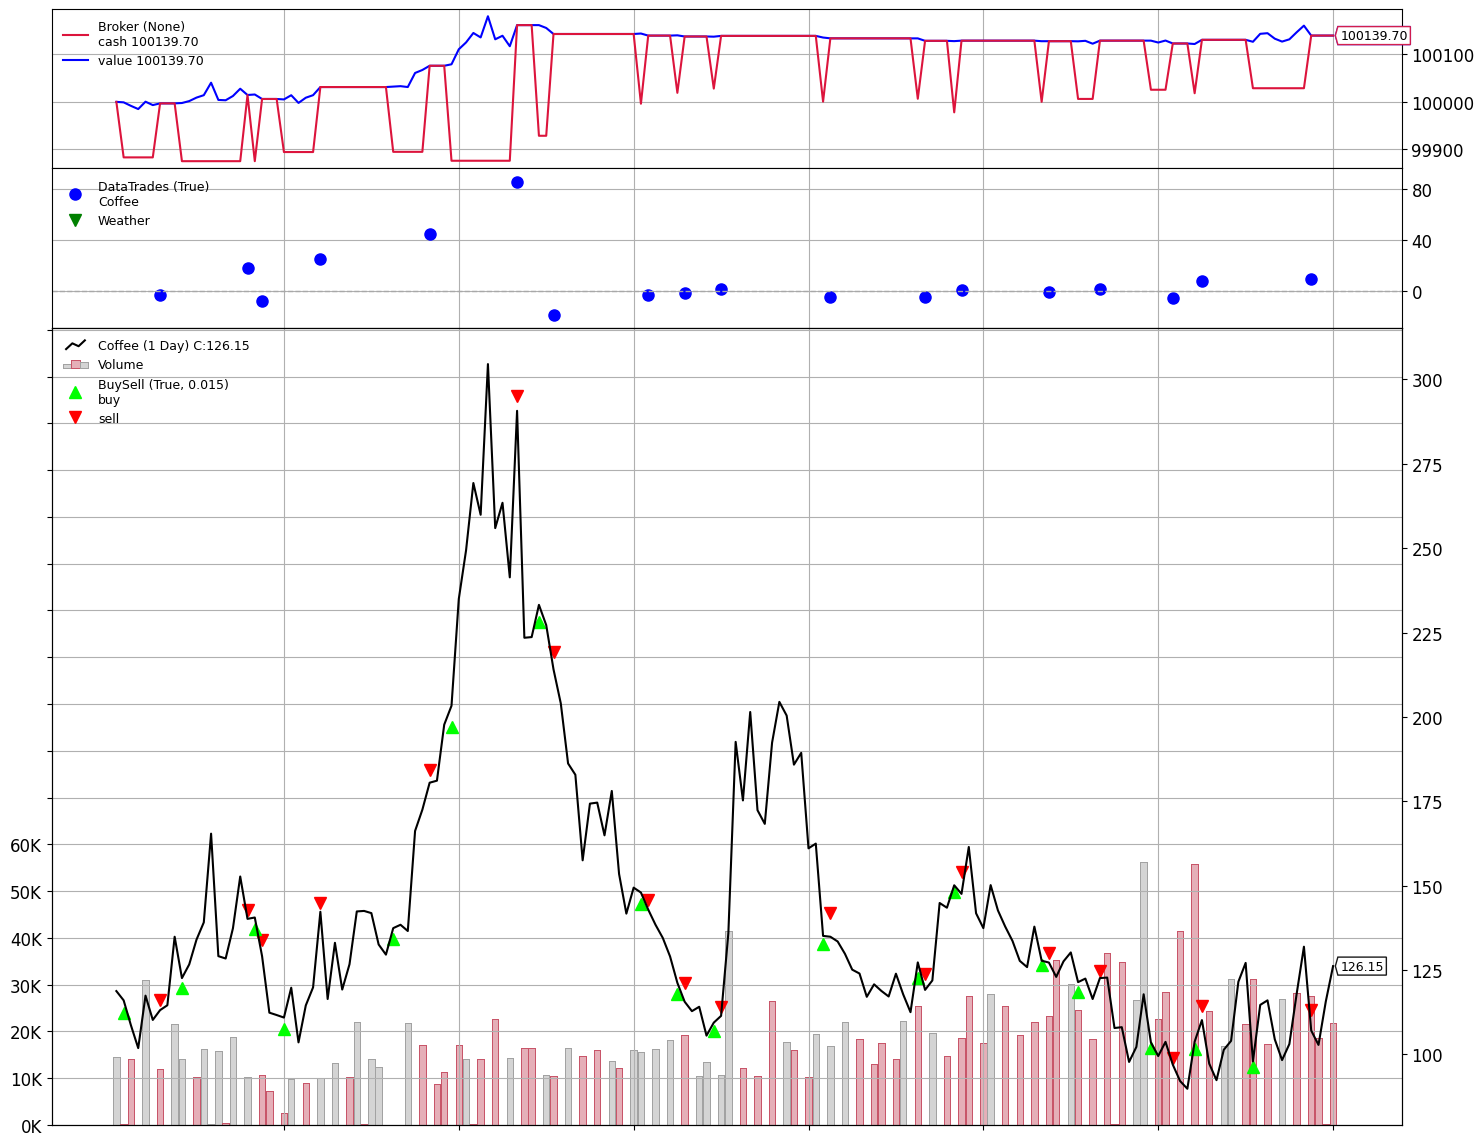

[[<Figure size 1500x1200 with 4 Axes>]]

In [196]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebroFirst.plot(iplot = False)

# Second Strategy Results

In [197]:
# Create Cerebro for the Second Strategy
cerebroSecond = bt.Cerebro()

# Add the strategy to Cerebro
cerebroSecond.addstrategy(SecondWeatherStrategy)

# Set the initial capital
cerebroSecond.broker.setcash(100000.0)

# Add the coffee data to Cerebro
cerebroSecond.adddata(coffee_feed, name='Coffee')

# Add the weather data to Cerebro
cerebroSecond.adddata(weather_feed, name='Weather')

print(f'Starting Portfolio Value: {cerebroSecond.broker.getvalue():.2f}')

# Run the backtest
cerebroSecond.run()

finalPValue_secondStrat = cerebroSecond.broker.getvalue()
print(f'Ending Portfolio Value: {finalPValue_secondStrat:.2f}')

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 120215.01


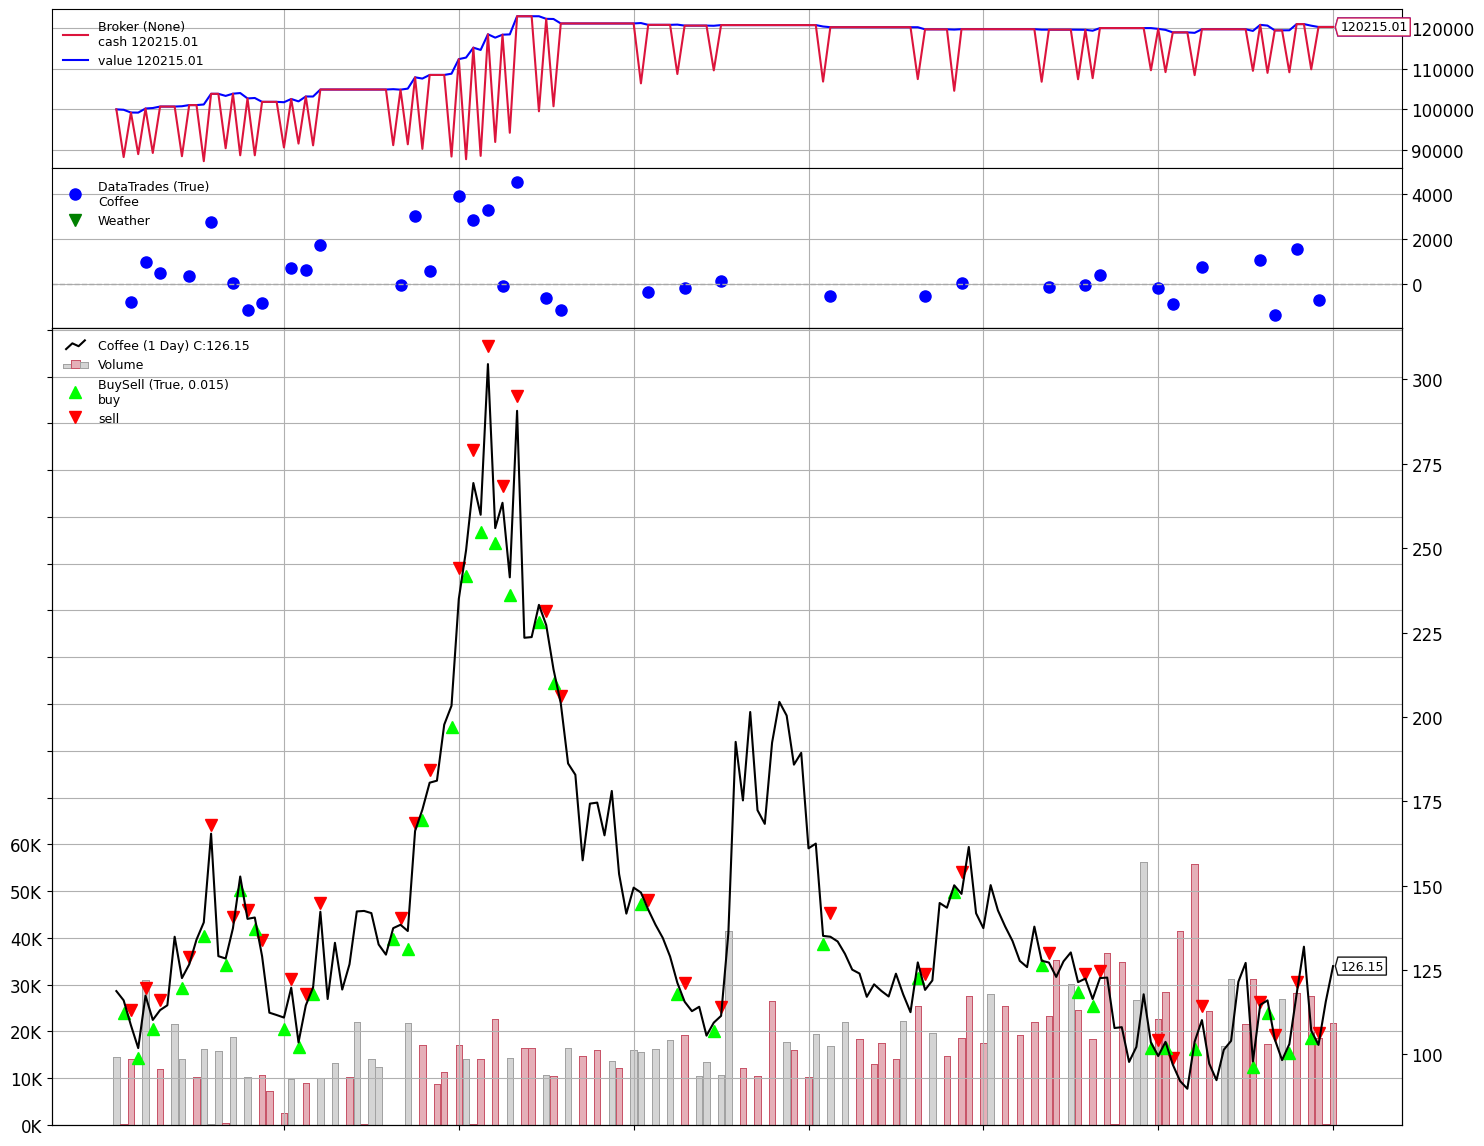

[[<Figure size 1500x1200 with 4 Axes>]]

In [198]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebroSecond.plot(iplot = False)

# Analysis of Results

In [199]:
print(f'The final value of the Portfolio applying the first strategy is: {finalPValue_firstStrat}')
print(f'The final value of the Portfolio applying the second strategy is: {finalPValue_secondStrat}')

# Get the profit for both strats
finalProfit_firstStrat = 100000-finalPValue_firstStrat
finalProfit_secondStrat = 100000-finalPValue_secondStrat

# Compare the 2 strats results
if finalPValue_firstStrat > finalPValue_secondStrat:
    print(f'This makes it so the First strategy is {(finalProfit_firstStrat-finalProfit_secondStrat)/finalProfit_secondStrat * 100}% more profitable than the Second one')
elif finalPValue_firstStrat < finalPValue_secondStrat:
    print(f'This makes it so the Second strategy is {(finalProfit_secondStrat-finalProfit_firstStrat)/finalProfit_firstStrat * 100}% more profitable than the First one')
else:
    print(f'Both strategies yield the same profit.')

The final value of the Portfolio applying the first strategy is: 100139.70002746582
The final value of the Portfolio applying the second strategy is: 120215.00549316406
This makes it so the Second strategy is 14370.294573213283% more profitable than the First one
